# Preprocessing

- The LPIS field parcel data (geometries and class labels) are cleaned and preprocssed by a geopandas pipeline.
- The RGB-Sentinel-2 imagery is cut to 128x128-pixel image chips. 
- The preprocessed LPIS data is clipped to matching chip geometries and saved in COCO annotation format.

This repository only contains data for a small subset of the full Denmark region of interest for demonstration purposes. Imagery and geometry data for the full roi would take up several gigabytes. The full 2016 LPIS "marker" dataset set can be downloaded here:
https://kortdata.fvm.dk/download/Markblokke_Marker?page=MarkerHistoriske

![Subset chip cutting example](msc_codeshare/test_aoi_subset.png)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import rasterio
import shapely
from PIL import Image as pilimage
import pprint

import utils
from utils.other import new_save, load_saved, load_or_new_save

In [2]:
fp_s2 = Path(r'data\RGB_small.tif')
fp_fields = Path(r'data\marker_small.shp')

out = Path(r'output\preprocessed')

### Vector preparation 

In [3]:
# Vector preparation

with rasterio.open(fp_s2) as src:
    raster_meta = src.meta
    raster_bounds = src.bounds

def prepare_vector(in_path, out_crs, clipping_bounds):
    df = (gpd.read_file(str(in_path), encoding='utf-8')  # contains danish special characters
             .rename(columns={'Afgroede': 'lc_name', 'AfgKode': 'lc_id', 'JOURNALNUM': 'journalnr'})
             .drop(['GB', 'GEOMETRISK', 'MARKNUMMER'], axis=1)
             .pipe(utils.geo.buffer_zero)
             .pipe(utils.geo.close_holes)
             .pipe(utils.geo.set_crs, 3044)
             .to_crs(out_crs)
             .pipe(utils.geo.clip, clip_poly=shapely.geometry.box(*clipping_bounds), explode_mp_=True)
             .pipe(utils.geo.reclassify_col, rcl_scheme=utils.geo.reclass_legend, 
                   col_classlabels='lc_name', col_classids='lc_id', drop_other_classes=True)
             .assign(geometry=lambda _df: _df.geometry.simplify(5, preserve_topology=True))
             .pipe(utils.geo.buffer_zero)
             .assign(area_sqm=lambda _df: _df.geometry.area)
             .pipe(utils.geo.reduce_precision, precision=4)
             .reset_index(drop=True)
             .assign(fid=lambda _df: range(0, len(_df.index)))
             .filter(['journalnr', 'lc_id', 'lc_name', 'rcl_lc_id', 'rcl_lc_name', 
                      'area_sqm', 'fid', 'geometry'])
          )
    return df


df = load_or_new_save(path=out / 'prepared_vector.pkl',
                      default_data=prepare_vector,
                      callable_args={'in_path': fp_fields, 
                                     'out_crs': raster_meta['crs'], 
                                     'clipping_bounds': raster_bounds})

print('df.info()', df.info())
display(df.head(3))

Writing new pickle file... prepared_vector.pkl
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 8 columns):
journalnr      113 non-null object
lc_id          113 non-null int64
lc_name        113 non-null object
rcl_lc_id      113 non-null int64
rcl_lc_name    113 non-null object
area_sqm       113 non-null float64
fid            113 non-null int32
geometry       113 non-null object
dtypes: float64(1), int32(1), int64(2), object(4)
memory usage: 6.7+ KB
df.info() None


,journalnr,lc_id,lc_name,rcl_lc_id,rcl_lc_name,area_sqm,fid,geometry
0,16-0036135,30,Ærter,5,other,18409.058038,0,"POLYGON ((513952.7684 6243596.0941, 514026.304..."
1,16-0044708,1,Vårbyg,1,springcereal,343798.036407,1,"POLYGON ((515394.05 6247182.35, 515511.8944 62..."
2,16-0053716,260,Græs med kløver/lucerne,4,grassland,202990.290354,2,"POLYGON ((512418.2498 6244766.2459, 512430.503..."


### Cut geometries to chips & export as COCO annotations

In [4]:
chip_width, chip_height = 128, 128

In [5]:
# Cut to chip geometries
all_chip_dfs = load_or_new_save(path=out / 'all_chip_dfs.pkl',
                                default_data=utils.geo.cut_chip_geometries,
                                callable_args={'vector_df': df,
                                               'raster_width': raster_meta['width'],
                                               'raster_height': raster_meta['height'],
                                               'raster_transform': raster_meta['transform'],
                                               'chip_width': chip_width,
                                               'chip_height': chip_height})

print('len', len(all_chip_dfs))

9it [00:00, 37.94it/s]


Writing new pickle file... all_chip_dfs.pkl
len 9


In [6]:
# Export geomtries as COCO annotation format
outpath_train = out / r'annotations\train2016.json'
outpath_val = out / r'annotations\val2016.json'

if outpath_train.exists() and outpath_val.exists():
    coco_train = load_saved(outpath_train, file_format='json')
    coco_val = load_saved(outpath_val, file_format='json')
else:
    train_chip_dfs, val_chip_dfs = utils.coco.train_test_split(all_chip_dfs, test_size=0.2)
    
    coco_train = utils.coco.format_coco(train_chip_dfs, chip_width, chip_height)
    new_save(outpath_train, coco_train, file_format='json')
    
    coco_val = utils.coco.format_coco(val_chip_dfs, chip_width, chip_height)
    new_save(outpath_val, coco_val, file_format='json')

Writing new json file... train2016.json
Writing new json file... val2016.json


### Cut images to chips 

In [7]:
# Cut to chip images and write to disk, retrieve chip image statistics

chip_windows = [value['chip_window'] for chip_name, value in all_chip_dfs.items()]
all_chip_stats = utils.img.cut_chip_images(fp_s2, 
                                           chip_windows=chip_windows, 
                                           out_folder=out / r'image_chips\train2016', 
                                           bands=[3, 2, 1])

utils.coco.move_coco_val_images(val_chips_list = val_chip_dfs.keys(), 
                                path_train_folder=out / r'image_chips\train2016')

print('len', len(all_chip_stats))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 34.96it/s]


len 9


### Statistics

In [10]:
# Gather chip statistics.

def gather_statistics():
    return {
        'nr_chips': len(all_chip_dfs.keys()),
        'nr_chips_train': len(train_chip_dfs),
        'nr_chips_val': len(val_chip_dfs),
        'nr_polys': sum([len(df['chip_df']) for df in all_chip_dfs.values()]),
        'nr_polys_train': sum([len(df['chip_df']) for df in train_chip_dfs.values()]),
        'nr_polys_val': sum([len(df['chip_df']) for df in val_chip_dfs.values()]),
        'avg_polys_per_chip': sum([len(df['chip_df']) for df in all_chip_dfs.values()]) / len(all_chip_dfs.keys()),
        'train_rgb_mean': list(np.asarray([df['mean'] for df in [all_chip_stats[key] for key in train_chip_dfs.keys()]]).mean(axis=0)),
        'train_rgb_std': list(np.asarray([df['std'] for df in [all_chip_stats[key] for key in train_chip_dfs.keys()]]).mean(axis=0)),
    }

statistics = load_or_new_save(path=out / 'statistics.json',
                              default_data=gather_statistics,
                              file_format='json')
pprint.pprint(statistics)

Writing new json file... statistics.json
{'avg_polys_per_chip': 19.0,
 'nr_chips': 9,
 'nr_chips_train': 7,
 'nr_chips_val': 2,
 'nr_polys': 171,
 'nr_polys_train': 123,
 'nr_polys_val': 48,
 'train_rgb_mean': [94.87407575334821, 106.43259974888393, 117.06084333147321],
 'train_rgb_std': [29.676533028155795, 14.783947366623368, 14.194860301379379]}


### Visualize preprocessed chip images and COCO annotations

Loading from json file... val2016.json
COCO_val2016_000000100005.jpg


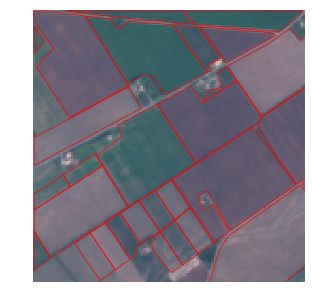

COCO_val2016_000000100006.jpg


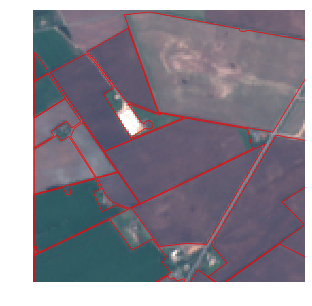

In [22]:
utils.coco.plot_coco(in_json=outpath_val, chip_img_folder=out / r'image_chips\val2016')